<a href="https://colab.research.google.com/github/TNTTNTTTN/Titanic_Survive_Prediction/blob/main/term_project_code_17011266_%EC%9D%B4%EC%88%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#-*- coding: utf-8 -*-
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)

df = pd.read_csv("/content/train.csv")
#df2 = pd.read_csv("/content/test.csv")
#df1.drop(labels='Survived', axis=1, inplace=True)
#df = pd.concat([df1, df2[:]], axis=0)
stscaler = StandardScaler()
mmscaler = MinMaxScaler()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2]:
def get_title(Name):
  if 'Mrs' in Name or 'Mme' in Name :
    Title='Mrs'
  elif 'Mr' in Name or 'Sir' in Name :
    Title='Mr'
  elif 'Miss' in Name or 'Ms' in Name or 'Mlle' in Name:
    Title='Miss'
  elif 'Master' in Name:
    Title='Master'
  else:
    Title='Else'
  return Title

In [3]:
df['Title'] = df['Name'].apply(lambda x : get_title(x))
df['Pclass'] = df['Pclass'].astype('string')
title_dic = {0:"Mrs", 1:"Mr", 2:"Miss", 3:"Master", 4:"Else"}

In [4]:
#df['Sex'] = df['Sex'].map({'male':0, 'female':1}).astype(int)
df.loc[(df['Sex']=='male') & (df['Age'].isnull()) & (df['Title']==title_dic[3]),'Age'] = 10
df.loc[(df['Sex']=='male') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='male']['Age'].mean()
df.loc[(df['Sex']=='female') & (df['Age'].isnull()),'Age'] = df[df['Sex']=='female']['Age'].mean()
#df['Age'] = df['Age'].apply(lambda x : classify_age(x))

In [5]:
df.loc[df['Fare'].isnull(),'Fare'] = df['Fare'].mean()

In [6]:
#df['Ncabin'] = df['Cabin'].str.extract('([A-F])', expand=False)
#df['Ncabin'] = df['Ncabin'].fillna("A")
df.loc[(df['Pclass']=="1") & (df['Fare'] > df[df['Pclass']=='1']['Fare'].median()),'Class'] = 'A'
df.loc[(df['Pclass']=="1") & (df['Fare'] <= df[df['Pclass']=='1']['Fare'].median()),'Class'] = 'B'
df.loc[(df['Pclass']=="2") & (df['Fare'] > df[df['Pclass']=='2']['Fare'].median()),'Class'] = 'C'
df.loc[(df['Pclass']=="2") & (df['Fare'] <= df[df['Pclass']=='2']['Fare'].median()),'Class'] = 'D'
df.loc[(df['Pclass']=="3") & (df['Fare'] > df[df['Pclass']=='3']['Fare'].median()),'Class'] = 'E'
df.loc[(df['Pclass']=="3") & (df['Fare'] <= df[df['Pclass']=='3']['Fare'].median()),'Class'] = 'F'

In [7]:
df.loc[(df['Pclass']==1) & (df['Cabin'].isnull()),'Cabin'] = 'C'
df.loc[(df['Pclass']==2) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df.loc[(df['Pclass']==3) & (df['Cabin'].isnull()),'Cabin'] = 'N'
df['Ncabin'] = df['Cabin'].str.extract('([A-G])', expand=False)
df['Ncabin'] = df['Ncabin'].fillna("N")

In [8]:
df['Family'] = df['SibSp']+df['Parch']
df.loc[df['Family'] > 3,'Family'] = 4
df['Family'] = df['Family'].astype('string')

In [9]:
stscaler.fit(df[['Age','Fare']])
scaled = stscaler.transform(df[['Age','Fare']])
mmscaler.fit(scaled)
output = mmscaler.transform(scaled)
output = pd.DataFrame(output, columns=['Age','Fare'])
df['Age'] = output['Age']
df['Fare'] = output['Fare']
#df['Ncabin'] = df['Ncabin'].astype(int)

In [10]:
df.drop(['PassengerId','Name', 'Ticket', 'SibSp','Parch', 'Sex', 'Cabin', 'Embarked'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    string 
 2   Age       891 non-null    float64
 3   Fare      891 non-null    float64
 4   Title     891 non-null    object 
 5   Class     891 non-null    object 
 6   Ncabin    891 non-null    object 
 7   Family    891 non-null    string 
dtypes: float64(2), int64(1), object(3), string(2)
memory usage: 55.8+ KB


In [11]:
#Survive = df.iloc[:,0]
#df = pd.get_dummies(df.iloc[:,1:])
df = pd.get_dummies(df,drop_first=True)
#df = pd.concat([Survive, df],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    int64  
 1   Age           891 non-null    float64
 2   Fare          891 non-null    float64
 3   Pclass_2      891 non-null    uint8  
 4   Pclass_3      891 non-null    uint8  
 5   Title_Master  891 non-null    uint8  
 6   Title_Miss    891 non-null    uint8  
 7   Title_Mr      891 non-null    uint8  
 8   Title_Mrs     891 non-null    uint8  
 9   Class_B       891 non-null    uint8  
 10  Class_C       891 non-null    uint8  
 11  Class_D       891 non-null    uint8  
 12  Class_E       891 non-null    uint8  
 13  Class_F       891 non-null    uint8  
 14  Ncabin_B      891 non-null    uint8  
 15  Ncabin_C      891 non-null    uint8  
 16  Ncabin_D      891 non-null    uint8  
 17  Ncabin_E      891 non-null    uint8  
 18  Ncabin_F      891 non-null    

In [12]:
df.head()

,Survived,Age,Fare,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Class_B,...,Ncabin_C,Ncabin_D,Ncabin_E,Ncabin_F,Ncabin_G,Ncabin_N,Family_1,Family_2,Family_3,Family_4
0,0,0.271174,0.014151,0,1,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
1,1,0.472229,0.139136,0,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
2,1,0.321438,0.015469,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0.434531,0.103644,0,0,0,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0
4,0,0.434531,0.015713,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
dataset = df.values
X = dataset[:,1:]
Y = dataset[:,0]
n_fold = 10
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=3)
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
accuracy =[]

In [14]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=50)
for train, test in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(16, input_dim=24, activation='sigmoid'))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
    model.fit(X[train], Y[train], validation_split=0.2, epochs=100, batch_size=16, callbacks=[early_stopping_callback], verbose=0)
    k_accuracy = "%.4f" % (model.evaluate(X[test], Y[test])[1])
    accuracy.append(float(k_accuracy))
print("\n %.f fold mean accuracy:" % n_fold, sum(accuracy)/n_fold)

3/3 [==============================] - 0s 4ms/step - loss: 0.4425 - binary_accuracy: 0.8202

 10 fold mean accuracy: 0.8238


In [15]:
accuracy

[0.8333, 0.7978, 0.8652, 0.8652, 0.8315, 0.8764, 0.7978, 0.809, 0.7416, 0.8202]

In [16]:
model = Sequential()
model.add(Dense(16, input_dim=24, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(X, Y, epochs=100, validation_split=0.2, batch_size=16, verbose=1)

Epoch 1/100
45/45 [==============================] - 1s 7ms/step - loss: 0.7095 - accuracy: 0.4551 - val_loss: 0.6864 - val_accuracy: 0.6648
Epoch 2/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6804 - accuracy: 0.5927 - val_loss: 0.6621 - val_accuracy: 0.6425
Epoch 3/100
45/45 [==============================] - 0s 3ms/step - loss: 0.6697 - accuracy: 0.6081 - val_loss: 0.6518 - val_accuracy: 0.6425
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 0.6662 - accuracy: 0.6081 - val_loss: 0.6441 - val_accuracy: 0.6425
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.6532 - accuracy: 0.6081 - val_loss: 0.6340 - val_accuracy: 0.6425
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.6565 - accuracy: 0.6081 - val_loss: 0.6251 - val_accuracy: 0.6425
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 0.6397 - accuracy: 0.6180 - val_loss: 0.6003 - val_accuracy: 0.6425
Epoch 8/100
4

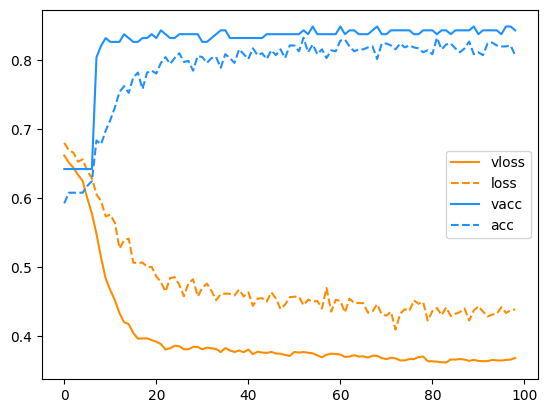

In [17]:
model_vloss = history.history['val_loss'][1:]
model_loss = history.history['loss'][1:]
model_accuracy = history.history['accuracy'][1:]
model_vaccuracy = history.history['val_accuracy'][1:]
x_len = np.arange(len(model_loss))

plt.plot(x_len, model_vloss, "-", c="DarkOrange", markersize=3, label="vloss")
plt.plot(x_len, model_loss, "--", c="DarkOrange", markersize=3, label="loss")
plt.plot(x_len, model_vaccuracy, "-", c="DodgerBlue", markersize=3, label="vacc")
plt.plot(x_len, model_accuracy, "--", c="DodgerBlue", markersize=3, label="acc")
plt.legend()
plt.show()

In [ ]:
model.save('please.h5')

In [ ]:
model = load_model('please.h5')
Y_prediction = model.predict(dataset).flatten()


In [ ]:
submission = pd.read_csv('gender_submission.csv')
submission['Survived'] = Y_prediction[891:]
submission.loc[submission['Survived'] < 0.5 ,'Survived'] = 0
submission.loc[submission['Survived'] >= 0.5 ,'Survived'] = 1
submission['Survived'] = submission['Survived'].astype(int)
submission.to_csv('sub.csv',index=False)